# Training EDA
Bu notebook, eğitim sırasında oluşan `trainer_state.json` (checkpoint içinde) ve `output/train_metrics.json` / `output/eval_metrics.json` dosyalarını toplayıp hızlı görselleştirmeler (loss, lr, epoch vs step) yapar.
Aşağıdaki hücreleri çalıştırarak eğitim geçmişini inceleyin.

In [25]:
# Imports
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
sns.set(style="darkgrid")

In [26]:
# Locate trainer_state.json files under models/ (checkpoints)
root = Path('..') if Path('..').exists() else Path('.')
search_dir = Path('models')
trainer_state_files = []
if search_dir.exists():
    trainer_state_files = sorted([p for p in search_dir.rglob('trainer_state.json')])
# also check output folder
out_dir = Path('output')
if out_dir.exists():
    trainer_state_files += sorted(list(out_dir.rglob('trainer_state.json')))
# dedupe and stringify
trainer_state_files = sorted(list(dict.fromkeys(trainer_state_files)))
trainer_state_files = [str(p) for p in trainer_state_files]
print(f'Found {len(trainer_state_files)} trainer_state.json files')

# Aggregate log_history entries from each trainer_state.json into a DataFrame
rows = []
for ts_path in trainer_state_files:
    try:
        st = json.loads(Path(ts_path).read_text(encoding='utf-8'))
        log_history = st.get('log_history', [])
        ckpt_name = str(Path(ts_path).parent)
        for entry in log_history:
            r = dict(entry)
            r['checkpoint'] = ckpt_name
            rows.append(r)
    except Exception as e:
        print('Failed to read', ts_path, e)

if rows:
    df = pd.DataFrame(rows)
    # normalize columns that might be missing
    for c in ['step','loss','epoch','learning_rate']:
        if c not in df.columns:
            df[c] = None
    df = df.sort_values('step').reset_index(drop=True)
else:
    df = pd.DataFrame(columns=['step','loss','epoch','learning_rate','checkpoint'])

print('Aggregated rows:', len(df))

df.head()


Found 0 trainer_state.json files
Aggregated rows: 0


,step,loss,epoch,learning_rate,checkpoint


## Checkpoint-5000 Analysis

Bu bölüm `models/finetuned/checkpoint-5000` içindeki dosyaları listeler, `trainer_state.json`'u okur ve training log history üzerinden loss / learning rate grafiklerini çizer. Notebook'u çalıştırırken GPU/CPU durumuna dikkat edin.

Project root: C:\Users\mehmet\Desktop\train

Listing files in C:\Users\mehmet\Desktop\train\models\finetuned\checkpoint-5000
- config.json
- eval_metrics.json
- eval_predictions.csv
- generation_config.json
- model.safetensors
- optimizer.pt
- rng_state.pth
- scheduler.pt
- special_tokens_map.json
- spiece.model
- tokenizer.json
- tokenizer_config.json
- trainer_state.json
- training_args.bin

Checkpoint log_history rows: 100


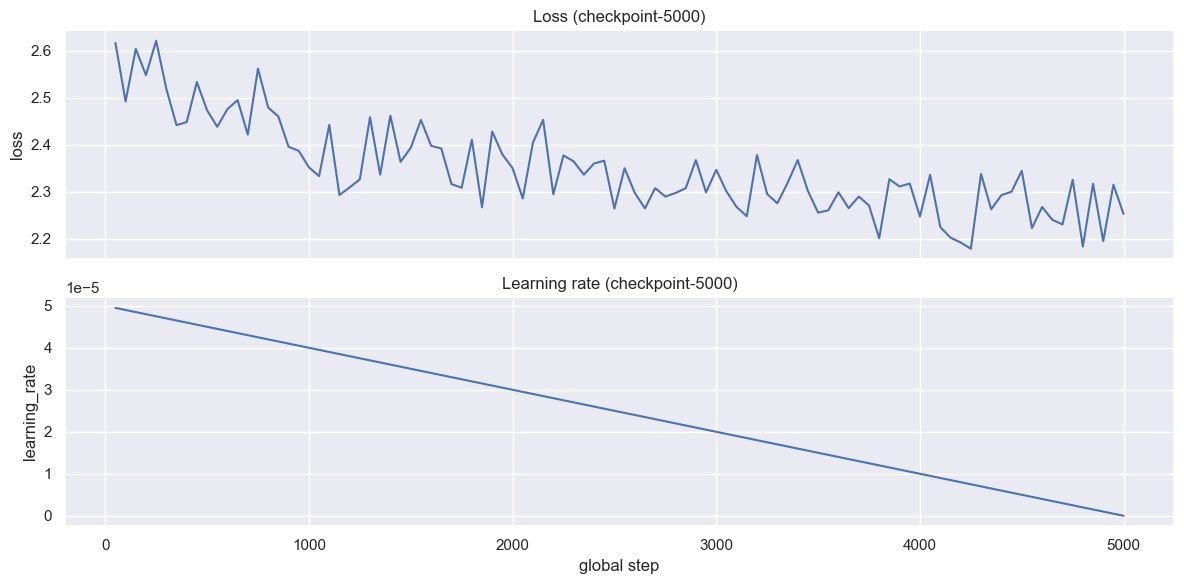

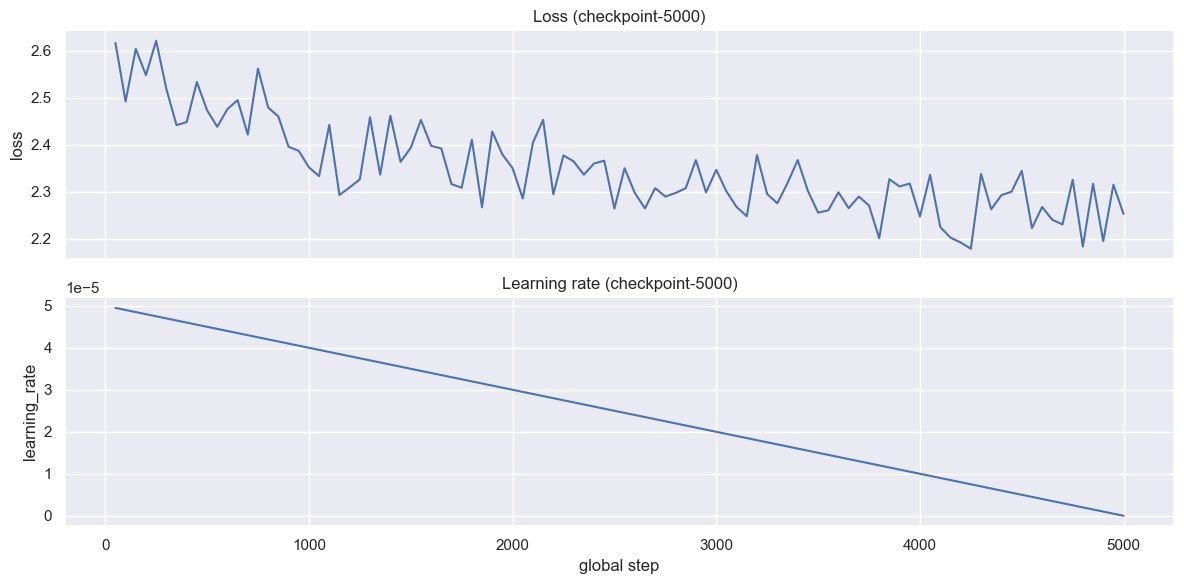

In [27]:
# Checkpoint-5000 inspection and plot (robust path resolution)
from pathlib import Path
from IPython.display import display

# Determine project root (use previously computed `root` if available)
try:
    project_root = root.resolve()
except NameError:
    project_root = Path('..').resolve() if Path('..').exists() else Path('.').resolve()

print('Project root:', project_root)

# Prefer explicit path under project root, fall back to searching the tree
ckpt = project_root / 'models' / 'finetuned' / 'checkpoint-5000'
if not ckpt.exists():
    print('Exact path not found:', ckpt)
    matches = list(project_root.rglob('checkpoint-5000'))
    if matches:
        ckpt = matches[0]
        print('Found checkpoint-5000 at:', ckpt)
    else:
        print('No checkpoint-5000 found under project root. Checked:', project_root)
        # show nearby checkpoints for debugging
        nearby = list((project_root / 'models' / 'finetuned').glob('checkpoint-*')) if (project_root / 'models' / 'finetuned').exists() else []
        if nearby:
            print('Nearby checkpoints:', [p.name for p in nearby])
        raise SystemExit('checkpoint-5000 not found')

# List files
print('\nListing files in', ckpt)
for p in sorted(ckpt.iterdir(), key=lambda x: x.name.lower()):
    print('-', p.name)

# load trainer_state.json if exists
ts = ckpt / 'trainer_state.json'
if ts.exists():
    st = json.loads(ts.read_text(encoding='utf-8'))
    lh = st.get('log_history', [])
    df_ck = pd.DataFrame(lh)
    if not df_ck.empty:
        for c in ['step','loss','epoch','learning_rate']:
            if c not in df_ck.columns:
                df_ck[c] = None
        df_ck = df_ck.sort_values('step').reset_index(drop=True)
        print('\nCheckpoint log_history rows:', len(df_ck))
        fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
        if df_ck['loss'].notna().any():
            sns.lineplot(data=df_ck, x='step', y='loss', ax=ax[0])
            ax[0].set_title('Loss (checkpoint-5000)')
        if df_ck['learning_rate'].notna().any():
            sns.lineplot(data=df_ck, x='step', y='learning_rate', ax=ax[1])
            ax[1].set_title('Learning rate (checkpoint-5000)')
        plt.xlabel('global step')
        plt.tight_layout()
        display(fig)
    else:
        print('trainer_state.json exists but has empty log_history')
else:
    print('No trainer_state.json in checkpoint-5000')


## ROUGE per-checkpoint analysis

Bu bölüm her checkpoint için depoda veya `output/` altında bulunan ROUGE metriklerini toplayıp karşılaştırır. Aşağıdaki hücreyi çalıştırarak checkpoint'ler arası ROUGE karşılaştırma grafiğini elde edin.

,checkpoint,step,rouge1,rouge2,rougeL
0,eval_metrics,-1,0.097692,0.035968,0.087671
1,grid_search_results,-1,NaN,NaN,NaN
2,rouge_eval,-1,0.099731,0.041630,0.088104
3,train_metrics,-1,0.146092,0.058805,NaN
4,checkpoint-500,500,0.000000,NaN,NaN
5,checkpoint-1500,1500,0.300000,0.111111,0.300000
6,checkpoint-5000,5000,0.315789,0.117647,0.315789
7,final,1000000000,NaN,NaN,NaN


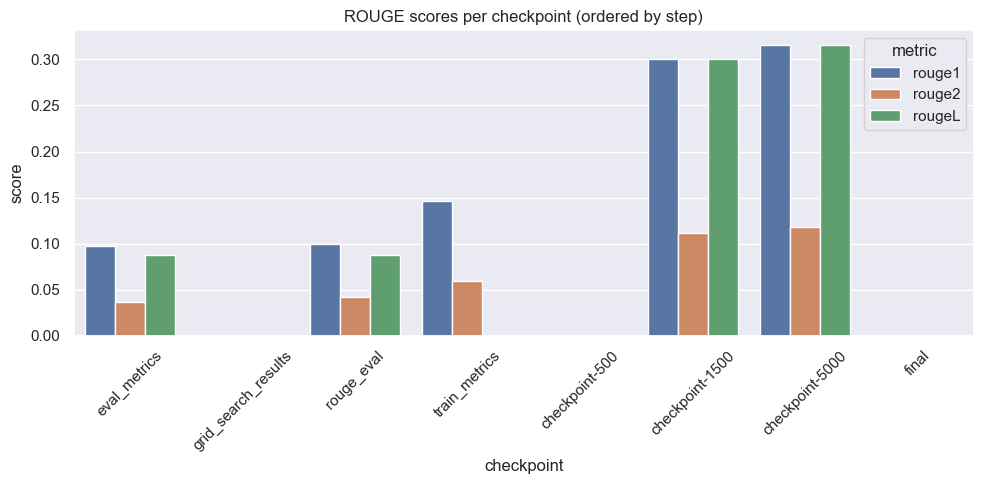

In [28]:
# Robust ROUGE per-checkpoint collection and ordered plot (improved)
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set(style='darkgrid')

project_root = project_root if 'project_root' in globals() else Path('.').resolve()
cp_dir = project_root / 'models' / 'finetuned'
rows = []


def find_key_recursive(d, key_lower):
    if not isinstance(d, dict):
        return None
    for k, v in d.items():
        if k.lower() == key_lower:
            return v
        if isinstance(v, dict):
            found = find_key_recursive(v, key_lower)
            if found is not None:
                return found
    return None


def extract_rouge_from_json(obj):
    # Try direct keys first
    if not isinstance(obj, dict):
        return None, None, None
    for k in ('rouge1','rouge_1','rouge-1'):
        if k in obj:
            rouge1 = obj.get(k)
            rouge2 = obj.get('rouge2') or obj.get('rouge_2') or obj.get('rouge-2')
            rougel = obj.get('rougeL') or obj.get('rouge_L') or obj.get('rouge-l')
            return rouge1, rouge2, rougel
    # common nested keys
    for parent in ('base_scores','adapter_scores','metrics'):
        if parent in obj and isinstance(obj[parent], dict):
            r = obj[parent]
            for k in ('rouge1','rouge_1','rouge-1'):
                if k in r:
                    return r.get(k), r.get('rouge2') or r.get('rouge_2') or r.get('rouge-2'), r.get('rougeL') or r.get('rouge_L') or r.get('rouge-l')
    # recursive search for any key that looks like rouge1/2/L
    r1 = find_key_recursive(obj, 'rouge1') or find_key_recursive(obj, 'rouge_1') or find_key_recursive(obj, 'rouge-1')
    r2 = find_key_recursive(obj, 'rouge2') or find_key_recursive(obj, 'rouge_2') or find_key_recursive(obj, 'rouge-2')
    rl = find_key_recursive(obj, 'rougeL') or find_key_recursive(obj, 'rouge_l') or find_key_recursive(obj, 'rouge-l')
    return r1, r2, rl

if not cp_dir.exists():
    print('Checkpoint dir not found:', cp_dir)
else:
    # gather checkpoint dirs matching checkpoint-<num> and also 'final'
    candidates = [d for d in cp_dir.iterdir() if d.is_dir()]
    ckpts = []
    for d in candidates:
        m = re.search(r'checkpoint-(\d+)', d.name)
        if m:
            ckpts.append((int(m.group(1)), d))
        elif d.name.lower().startswith('final'):
            ckpts.append((10**9, d))
    # sort by numeric step
    ckpts = sorted(ckpts, key=lambda x: x[0])

    # check output-level metrics too (global)
    out_dir = project_root / 'output'
    out_candidates = []
    if out_dir.exists():
        out_candidates = list(out_dir.glob('*.json'))
        # add output jsons as separate rows so you see global metrics
        for oc in out_candidates:
            try:
                j = json.loads(oc.read_text(encoding='utf-8'))
                r1,r2,rl = extract_rouge_from_json(j)
                rows.append({'checkpoint': oc.stem, 'step': -1, 'rouge1': r1, 'rouge2': r2, 'rougeL': rl})
            except Exception:
                continue

    for step, ck in ckpts:
        info = {'checkpoint': ck.name, 'step': step, 'rouge1': None, 'rouge2': None, 'rougeL': None}
        found = False
        # look for common files in checkpoint
        for fname in ['eval_metrics.json','rouge_eval.json','metrics.json']:
            f = ck / fname
            if f.exists():
                try:
                    j = json.loads(f.read_text(encoding='utf-8'))
                    r1,r2,rl = extract_rouge_from_json(j)
                    info.update({'rouge1': r1, 'rouge2': r2, 'rougeL': rl})
                    found = True
                    break
                except Exception:
                    continue
        if not found:
            # search recursively in checkpoint for any json that contains rouge
            for cand in ck.rglob('*.json'):
                try:
                    j = json.loads(cand.read_text(encoding='utf-8'))
                    r1,r2,rl = extract_rouge_from_json(j)
                    if any(v is not None for v in (r1,r2,rl)):
                        info.update({'rouge1': r1, 'rouge2': r2, 'rougeL': rl})
                        found = True
                        break
                except Exception:
                    continue
        rows.append(info)

# Build DataFrame, ensure order
df_r = pd.DataFrame(rows)
if df_r.empty:
    print('No checkpoint metrics found. Check that checkpoints exist and metrics were saved.')
else:
    df_r[['rouge1','rouge2','rougeL']] = df_r[['rouge1','rouge2','rougeL']].apply(pd.to_numeric, errors='coerce')
    df_r = df_r.sort_values(['step','checkpoint'])
    display(df_r)
    # plot keeping order
    melt = df_r.melt(id_vars=['checkpoint','step'], value_vars=['rouge1','rouge2','rougeL'], var_name='metric', value_name='score')
    plt.figure(figsize=(10,5))
    sns.barplot(data=melt, x='checkpoint', y='score', hue='metric', order=df_r['checkpoint'].tolist())
    plt.xticks(rotation=45)
    plt.title('ROUGE scores per checkpoint (ordered by step)')
    plt.tight_layout()
    plt.show()
